# fbb skeleton notebook for PUI2017 HW6

In [39]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import statsmodels.formula.api as smf
import urllib.request
import zipfile

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [40]:
os.getenv("PUIDATA")

'C:/Users/caoba/Google_Drive/PUI2017/PUIdata'

In [41]:
PUIDATA = os.getenv("PUIDATA")

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!

An interesting urban question is "can we measure and predict **energy use** based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the **number of units** in the building?

Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

Either obtain the data through the API or download the csv file, and move it to $PUIDATA

However this datasets does **not** have the number of units. We can find that in the Pluto dataset.

Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [42]:
#download, and move data to PUIDATA, and read data in 
filename = os.path.join(PUIDATA, 'mn_mappluto_16v2.zip')

urllib.request.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip', 
                               filename)

zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(os.path.join(PUIDATA, 'mn_mappluto_16v2'))
zip_ref.close()

nrg = pd.read_csv('https://data.cityofnewyork.us/resource/m46j-75iy.csv')
bsize = gp.read_file(PUIDATA + '/mn_mappluto_16v2/MNMapPLUTO.shp')

In [43]:
nrg.columns

Index(['automatic_water_benchmarking_eligible', 'bbls_co_reported', 'bin',
       'borough', 'census_tract', 'co_reported_bbl_status', 'community_board',
       'community_council', 'direct_ghg_emissions_mtco2e',
       'dof_benchmarking_submission_status', 'dof_number_of_buildings',
       'dof_property_floor_area_buildngs_and_parking_ft2', 'energy_star_score',
       'indirect_ghg_emissions_mtco2e', 'latitude', 'longitude',
       'municipally_supplied_potable_water_indoor_intensity_gal_ft', 'nta',
       'nyc_borough_block_and_lot_bbl', 'primary_property_type_self_selected',
       'record_number', 'reported_nyc_building_identificaiton_numbers_bins',
       'reported_property_floor_area_building_s_ft', 'reported_water_method',
       'site_eui_kbtu_ft2', 'source_eui_kbtu_ft2', 'street_name',
       'street_number', 'total_ghg_emissions_mtco2e',
       'weather_normalized_site_eui_kbtu_ft2',
       'weather_normalized_source_eui_kbtu_ft2', 'zip_code'],
      dtype='object')

In [44]:
bsize.columns
bsize.shape

(42686, 88)

In [45]:
# make sure you clean up your data and throw away columns you do not need!
bsize = bsize[['BBL', 'UnitsRes', 'UnitsTotal']]
nrg = nrg[['nyc_borough_block_and_lot_bbl', 'site_eui_kbtu_ft2', 'reported_property_floor_area_building_s_ft']]

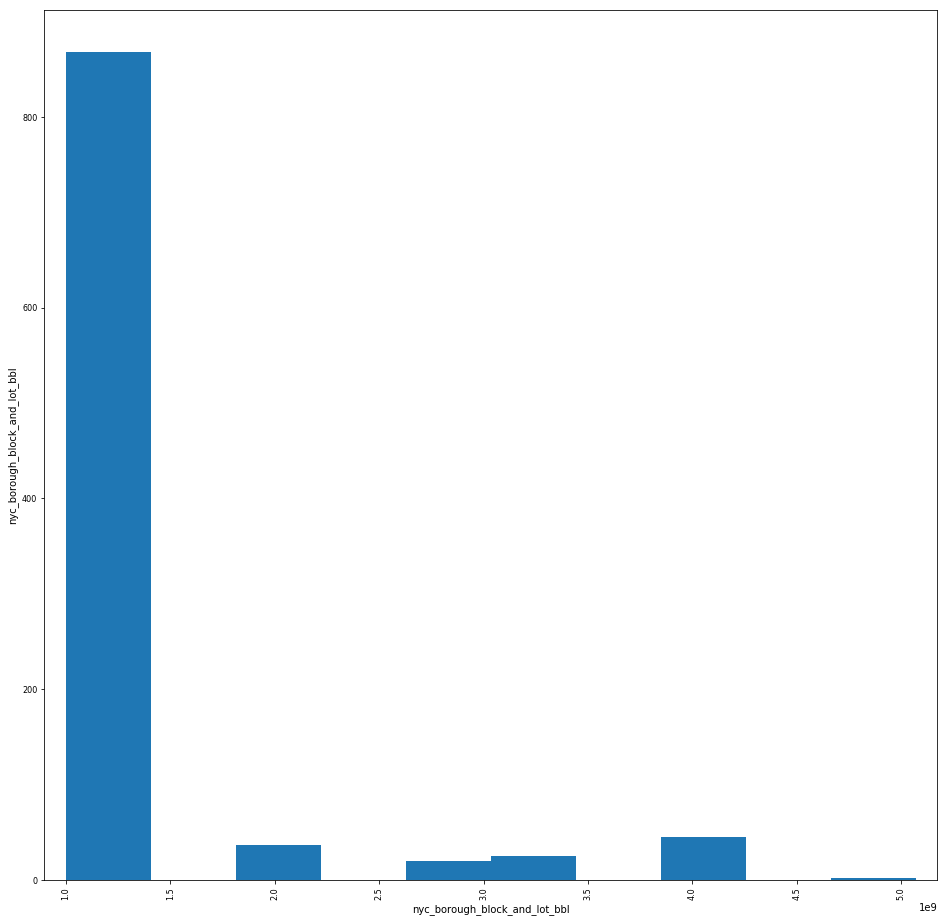

In [46]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));

Figure 1: scatter matrix of all numerical values in the files.

1. This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted:those that **contain only numbers** (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas **refuses** to plot them, cause it does not know what to do with those entries. 

2. The columns I am interested in are in fact **site_eui_kbtu_ft2** which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. **reported_property_floor_area_building_s_ft**. Neither gets plotted: i need to **remove all values that cannot conver to float** in order to use the columns and co
nvert them to float arrays and do math with them.

3. Below I created a function that returns True if what is passed as argument **can** be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.

4. This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..." However you can pass it a whole array by using it in conjunction with `np.vectorize` (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [47]:
# use pd.to_numeric to convert strings to numeric values,
# use errors=coerce to set missing values to nan
nrg.site_eui_kbtu_ft2 = pd.to_numeric(nrg.site_eui_kbtu_ft2, errors = 'coerce')
nrg.reported_property_floor_area_building_s_ft = pd.to_numeric(nrg.reported_property_floor_area_building_s_ft, errors = 'coerce')
##check that your conversion worked: e.g.
# print (nrg.site_eui_kbtu_ft2.astype(float))
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
bsize.BBL = bsize.BBL.astype(float)
#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

In [48]:
nrg.head()

,nyc_borough_block_and_lot_bbl,site_eui_kbtu_ft2,reported_property_floor_area_building_s_ft
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


In [49]:
# prepare your BBL columns
nrg = nrg.rename(columns = {'nyc_borough_block_and_lot_bbl':'BBL'})
#merge
bblnrgdata = pd.merge(nrg, bsize, how = 'left', on = 'BBL')

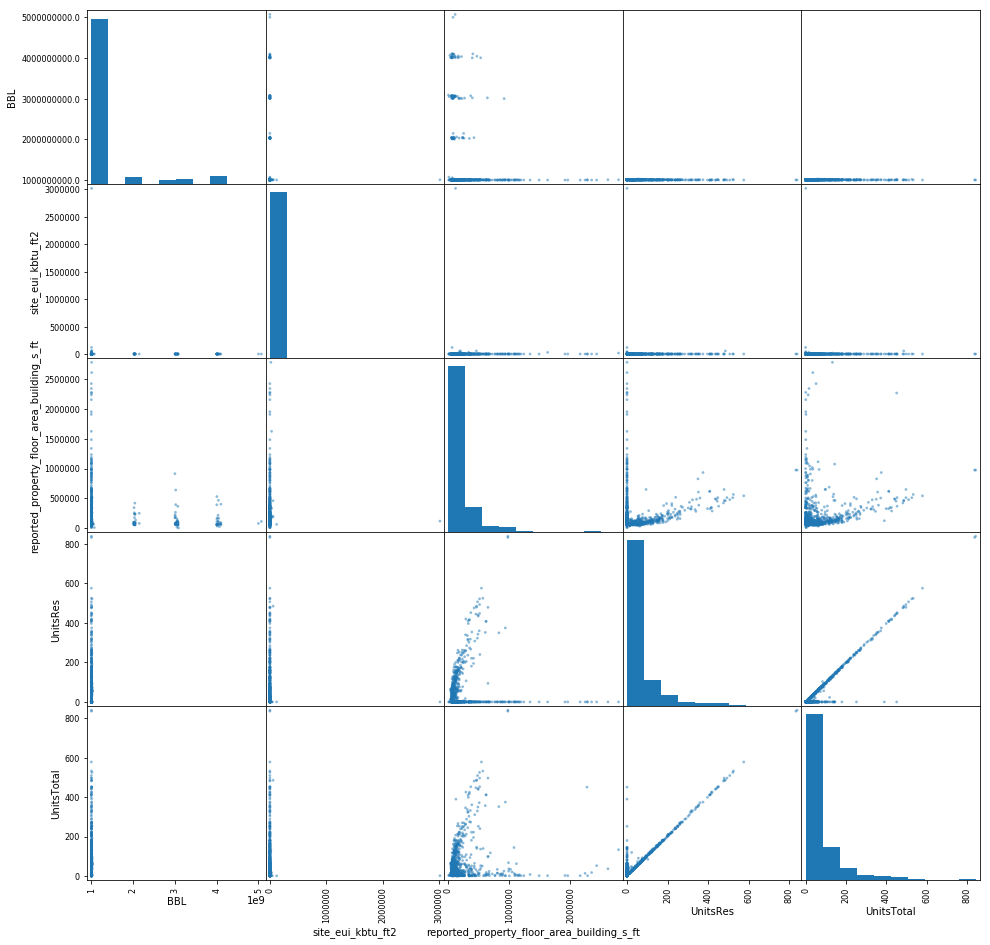

In [50]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16));

In [51]:
bblnrgdata['energy_total'] = bblnrgdata.site_eui_kbtu_ft2 * bblnrgdata.reported_property_floor_area_building_s_ft

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

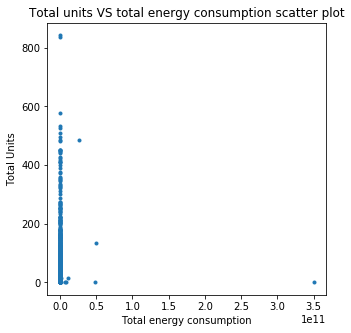

In [52]:
# we are using number of total units here, not residential units
fig = pl.figure(figsize = (5,5))
pl.plot(bblnrgdata.energy_total, bblnrgdata.UnitsTotal,'.')
pl.xlabel('Total energy consumption')
pl.ylabel('Total Units')
pl.title('Total units VS total energy consumption scatter plot')

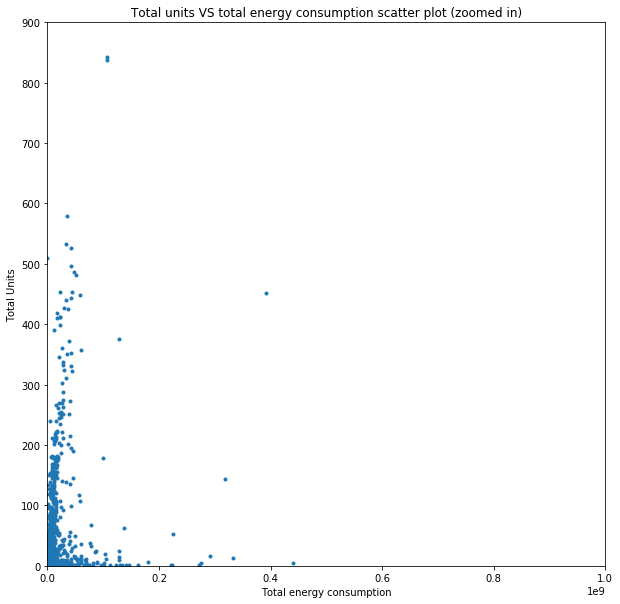

In [53]:
# zoomed in scatter plot
fig = pl.figure(figsize = (10,10))
pl.plot(bblnrgdata.energy_total, bblnrgdata.UnitsTotal,'.')
plt.axis([0,1e9,0,900])
pl.xlabel('Total energy consumption')
pl.ylabel('Total Units')
pl.title('Total units VS total energy consumption scatter plot (zoomed in)');


when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have **nrg==0 (or nrg < some sensible threshold choice)** by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [54]:
#remove outliers
bblnrgdata = bblnrgdata[(bblnrgdata.energy_total >= 1e3) & 
#                         (bblnrgdata.energy_total <= 0.6*1e9) & 
                        (bblnrgdata.UnitsTotal < 1000) &
                        (bblnrgdata.UnitsTotal > 10)
                       ]

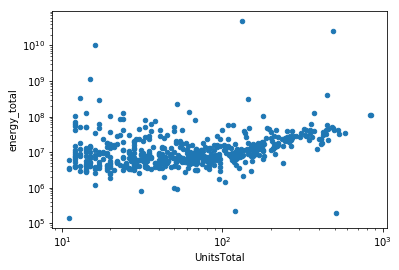

In [55]:
bblnrgdata.plot('UnitsTotal', 'energy_total', kind = 'scatter', loglog=True);

In [56]:
bblnrgdata.shape

(555, 6)

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [57]:
bblnrgdata['log10_energy_ttl'] = np.log10(bblnrgdata.energy_total)
bblnrgdata['log10_unit_ttl'] = np.log10(bblnrgdata.UnitsTotal)

reg1 = smf.ols('log10_energy_ttl ~ log10_unit_ttl', bblnrgdata).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log10_energy_ttl   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     43.08
Date:                Mon, 23 Oct 2017   Prob (F-statistic):           1.21e-10
Time:                        15:32:40   Log-Likelihood:                -373.89
No. Observations:                 555   AIC:                             751.8
Df Residuals:                     553   BIC:                             760.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.4886      0.085     75.981      0.000       6.321       6.656
log10_unit_ttl     0.3073      0.047      6.564      0.000       0.215       0.399
==============================================================================
Omnibus:                      315.847   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4773.045
Skew:                           2.169   Prob(JB):                         0.00
Kurtosis:                      16.696   Cond. No.                         9.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 

1. **Fit a line** to Units vs Energy. 
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is 
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
    $data(x_i)$ 
    is your observation, 
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors??)
    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



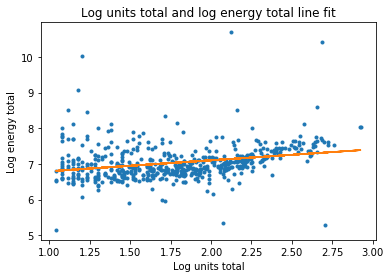

In [58]:
pl.plot(bblnrgdata.log10_unit_ttl, bblnrgdata.log10_energy_ttl, '.')
pl.plot(bblnrgdata.log10_unit_ttl, reg1.predict(), '-')
pl.xlabel('Log units total')
pl.ylabel('Log energy total')
pl.title('Log units total and log energy total line fit');

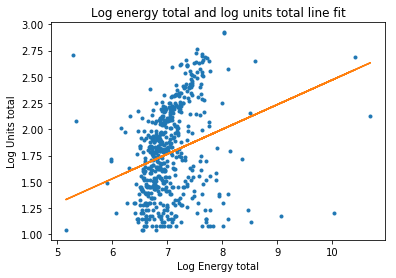

In [59]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)
reg2 = smf.ols('log10_unit_ttl ~ log10_energy_ttl', bblnrgdata).fit()
reg2.summary()

pl.plot(bblnrgdata.log10_energy_ttl, bblnrgdata.log10_unit_ttl, '.')
pl.plot(bblnrgdata.log10_energy_ttl, reg2.predict(), '-')
pl.xlabel('Log Energy total')
pl.ylabel('Log Units total')
pl.title('Log energy total and log units total line fit');

In [67]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [69]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log

KeyError: 'Reported Property Floor Area'

No we cannot compare these models with liklihood ratio test because these models are not nested.

In [63]:
# calculate chisq
def get_chisq(data, model):
    chisq = sum(list(map(lambda a,b: ((a-b)**2)/b, model, data)))
    return(chisq)

In [64]:
chisq1 = get_chisq(bblnrgdata.log10_energy_ttl, reg1.predict())
chisq2 = get_chisq(bblnrgdata.log10_unit_ttl, reg2.predict())

In [65]:
print('chisq1 is', chisq1)
print('chisq2 is', chisq2)

chisq1 is 16.2117551835
chisq2 is 59.6273902262


Based on the Chi-square test, we observe that the fist model is the better fit. Since we assumed that the error follows poisson statistics, hence the error is the square root of the measurement. 

In [25]:
reg3 = smf.ols('log10_energy_ttl ~ log10_unit_ttl + I(log10_unit_ttl**2)', bblnrgdata).fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log10_energy_ttl   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     54.06
Date:                Mon, 23 Oct 2017   Prob (F-statistic):           3.73e-22
Time:                        13:58:03   Log-Likelihood:                -252.50
No. Observations:                 551   AIC:                             511.0
Df Residuals:                     548   BIC:                             523.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.2386      0.265     31.051      0.000       7.717       8.760
log10_unit_ttl            -1.7317      0.299     -5.800      0.000      -2.318      -1.145
I(log10_unit_ttl ** 2)     0.5539      0.081      6.854      0.000       0.395       0.713
==============================================================================
Omnibus:                       76.825   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              705.216
Skew:                           0.183   Prob(JB):                    7.32e-154
Kurtosis:                       8.530   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

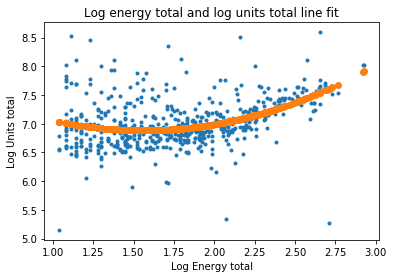

In [26]:
pl.plot(bblnrgdata.log10_unit_ttl, bblnrgdata.log10_energy_ttl, '.')
pl.plot(bblnrgdata.log10_unit_ttl, reg3.predict(), 'o')
pl.xlabel('Log Energy total')
pl.ylabel('Log Units total')
pl.title('Log energy total and log units total line fit');

Null hypothesis: line fit is as good or better than the 2 degree polynomial fit

In [27]:
print ("LR : ", -2 * (-reg3.llf - (-reg1.llf)))
print ("LR from statsmodels:", reg3.compare_lr_test(reg1))

LR :  45.3137414106
LR from statsmodels: (45.31374141060428, 1.6786718326189766e-11, 1.0)


Since LR is Chisquare distributed, we observe that the LR-statistics is larger than 3.84 (Chisquare statistics at alpha = 0.05, DOF = 1), therefore we reject the null hypothesis, the 2 degree polynomial fit is better in this case. 

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

NameError: name 'Lsurface' is not defined

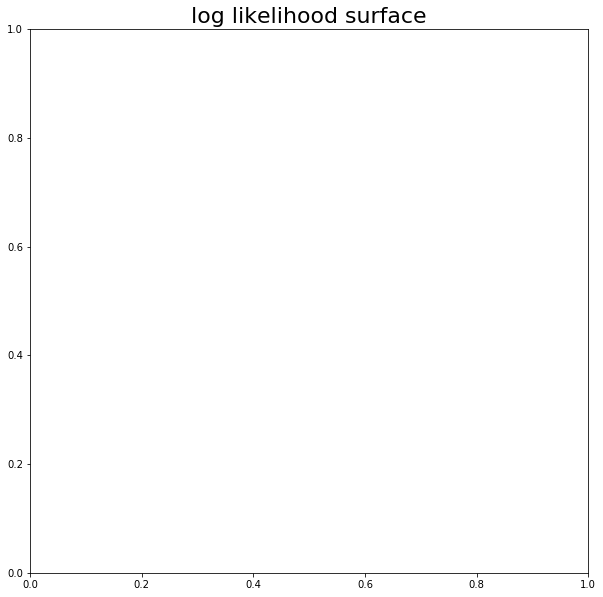

In [28]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

In [ ]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)